In [3]:
# Standard Libraries
import sys
import os
import collections

# Helper Libraries
import tqdm

# Data Science Libraries
import pandas as pd
import numpy as np
import optuna

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn as sk
import lightgbm
import xgboost
import catboost

# Project Libraries
import optiver2023

# Configure Visualization
%matplotlib inline
plt.style.use('bmh')
# sns.set_style('white')

# Configure Pandas and SKLearn
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.precision", 3)
sk.set_config(display="diagram")

# File Specific Configurations
DATA_DIR = "/kaggle/input/optiver-trading-at-the-close/"
START = pd.Timestamp.now()
SEED = 42

# Inspect Versions
print("Python version:", sys.version)
print("Interpreter PATH:", sys.executable)
print("Working PATH:", os.getcwd())

print("-" * 50, "\n", sep="")
print("pandas version:", pd.__version__)
print("optuna version:", optuna.__version__)
print("sklearn version:", sk.__version__)

print("-" * 50, "\n", sep="")
print("Notebook Start Time:", START.strftime("%Y-%m-%dT%H.%M.%S"))

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
Interpreter PATH: /opt/conda/bin/python3.10
Working PATH: /kaggle/working
--------------------------------------------------

pandas version: 2.0.3
optuna version: 3.3.0
sklearn version: 1.2.2
--------------------------------------------------

Notebook Start Time: 2023-09-30T22.07.18


# 1. Explore & Explain the Data

## 1.1 缺失值

In [4]:
def inspect_columns(df):
    # A helper function that does a better job than df.info() and df.describe()
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

In [5]:
Xy_train = pd.read_csv(DATA_DIR + "train.csv")
Xy_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.181e+06,1,1.0,1.338e+07,NaN,NaN,1.000,60651.50,1.000,8493.03,1.0,-3.03,0,0_0_0
1,1,0,0,1.666e+05,-1,1.0,1.642e+06,NaN,NaN,1.000,3233.04,1.001,20605.09,1.0,-5.52,0,0_0_1
2,2,0,0,3.029e+05,-1,1.0,1.819e+06,NaN,NaN,0.999,37956.00,1.000,18995.00,1.0,-8.39,0,0_0_2
3,3,0,0,1.192e+07,-1,1.0,1.839e+07,NaN,NaN,1.000,2324.90,1.000,479032.40,1.0,-4.01,0,0_0_3
4,4,0,0,4.475e+05,-1,1.0,1.786e+07,NaN,NaN,0.999,16485.54,1.000,434.10,1.0,-7.35,0,0_0_4


In [6]:
inspect_columns(Xy_train)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,132,199,int64
date_id,False,481,False,0.00,0,241,480,int64
seconds_in_bucket,False,55,False,0.00,0,520,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,632646.41,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,1,-1,int64
reference_price,False,28741,True,0.00,1.0,0.999,1.002,float64
matched_size,False,2948862,True,0.00,13380276.64,14056728.29,24073677.32,float64
far_price,False,95739,True,55.26,NaN,1.0,1.001,float64
near_price,False,84625,True,54.55,NaN,1.0,1.001,float64
bid_price,False,28313,True,0.00,1.0,0.999,1.002,float64


In [7]:
# Take a look of any single time series by setting stock_id and date_id

stock_id = 10
date_id = 100

(Xy_train
    .query(f'stock_id == {stock_id} & date_id == {date_id}')
    .drop(columns=['stock_id', 'date_id', 'time_id', 'row_id'])
    .head(10)
)

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
1067285,0,1.202e+06,1,1.0,3.897e+06,NaN,NaN,1.000,14007.32,1.0,412.06,1.0,1.301
1067482,10,1.121e+06,1,1.0,3.977e+06,NaN,NaN,1.000,1441.93,1.0,9477.84,1.0,0.980
1067679,20,1.121e+06,1,1.0,3.978e+06,NaN,NaN,1.000,7415.64,1.0,9477.84,1.0,-0.970
1067876,30,1.121e+06,1,1.0,3.978e+06,NaN,NaN,1.000,18333.11,1.0,21845.54,1.0,-1.190
1068073,40,6.943e+05,1,1.0,4.404e+06,NaN,NaN,1.000,19157.07,1.0,21845.54,1.0,-0.420
1068270,50,6.630e+05,1,1.0,4.436e+06,NaN,NaN,1.000,14829.12,1.0,617.94,1.0,6.551
1068467,60,6.628e+05,1,1.0,4.436e+06,NaN,NaN,1.000,20597.00,1.0,8655.36,1.0,2.290
1068664,70,6.921e+05,1,1.0,4.407e+06,NaN,NaN,1.000,20594.00,1.0,4119.80,1.0,2.460
1068861,80,5.853e+05,1,1.0,4.518e+06,NaN,NaN,0.999,33359.04,1.0,7414.56,1.0,3.570
1069058,90,5.853e+05,1,1.0,4.518e+06,NaN,NaN,1.000,4324.74,1.0,21832.82,1.0,4.190


What type of data missing?

In [8]:
# Let's first exam if all the time series are 55 steps long

(Xy_train
    .groupby(['stock_id', 'date_id'])
    ['seconds_in_bucket'] # Extract the column of interest
    .count() # Count the number of rows in each permutation of stock_id and date_id
    .apply(lambda x: x == 55) # Check if every count is 55
    .all() # Check if all the booleans are True
)

True

The above result suggests that all the time series in our training data are of the same length of 55.

It can be concluded that **there are some stocks missing data in some days entirely**.

Next, let's keep exploring which stocks are missing data on which days?

In [9]:
all_stock_id = np.sort(Xy_train["stock_id"].unique())
print(all_stock_id[:10])
print(all_stock_id[-10:])

[0 1 2 3 4 5 6 7 8 9]
[190 191 192 193 194 195 196 197 198 199]


In [10]:
all_date_id = np.sort(Xy_train["date_id"].unique())
print(all_date_id[:10])
print(all_date_id[-10:])

[0 1 2 3 4 5 6 7 8 9]
[471 472 473 474 475 476 477 478 479 480]


In [11]:
# Make a MultiIndex object from the cartesian product of all possible combinations.
multi_index = pd.MultiIndex.from_product(
    iterables=[all_date_id, all_stock_id], 
    names=["date_id", "stock_id"]
)

# To get the all missing data.
# join the MultiIndex with the Trianing data,
# and then filter out all the rows that are not in the training data.
missing_data = (Xy_train
    .loc[:, ["date_id", "stock_id"]]
    .assign(in_train=True) # Add a new column to indicate if the row is in the training data
    .set_index(["date_id", "stock_id"])
    .merge(multi_index.to_frame(), how="right", left_index=True, right_index=True)
    .query("in_train.isna()") # Filter out the missing data
    .set_index("stock_id", drop=True)
    ["date_id"]
)

# A Series object for missing data
missing_data

stock_id
69       0
78       0
79       0
102      0
135      0
      ... 
102    291
102    292
102    293
102    294
73     320
Name: date_id, Length: 964, dtype: int64

In [12]:
# Show all the stock_id that have at least 1 day of missing data
missing_data.index.unique()

Index([69, 78, 79, 102, 135, 150, 153, 156, 199, 99, 73], dtype='int64', name='stock_id')

In [13]:
# See which date's data is missing for a specific stock_id
stock_id = 78
missing_data[stock_id]

stock_id
78    0
78    1
78    2
78    3
Name: date_id, dtype: int64

In [14]:
# A summary of the of missing date counts for each stock_id
missing_data.groupby("stock_id").count()

stock_id
69      37
73       1
78       4
79     181
99       1
102    295
135    191
150     59
153     70
156     37
199     88
Name: date_id, dtype: int64

The `missing_data` could be useful for later modeling.

## 1.2. Understand the features

In [15]:
def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

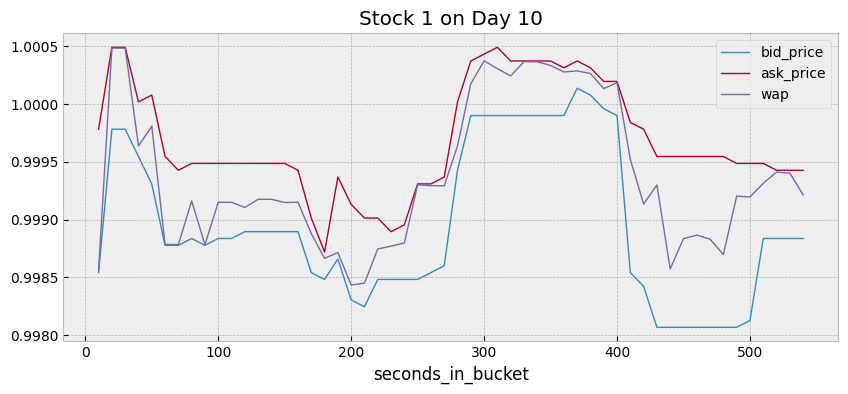

In [62]:
# We tried a few different stock_id and date_id to see the common patterns

time_series_plot(
    df=Xy_train, 
    cols=['bid_price','ask_price', 'wap',], 
    stock_id = 1,
    date_id = 10
)

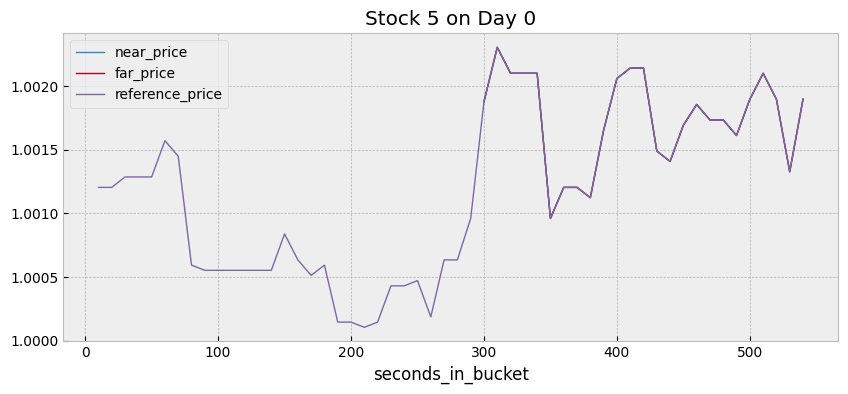

In [18]:
# How the auction & combined book pricing changes during the auction?
time_series_plot(
    df=Xy_train, 
    cols=['near_price','far_price','reference_price'], 
    stock_id = 5, 
    date_id = 0
)

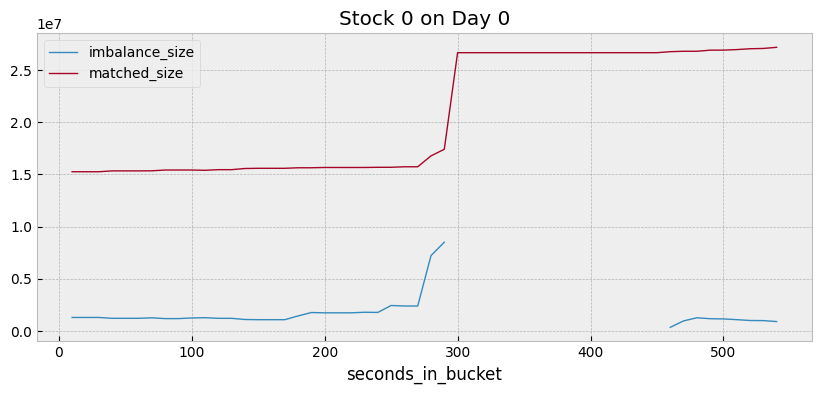

In [19]:
time_series_plot(
    df=Xy_train, 
    cols=['imbalance_size','matched_size'], 
    stock_id = 0, 
    date_id = 0
)

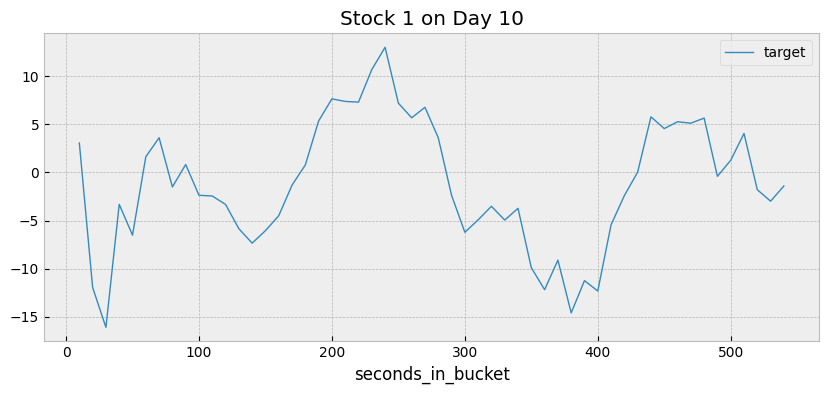

In [63]:
time_series_plot(
    df=Xy_train, 
    cols=['target'], 
    stock_id = 1,
    date_id = 10
)

In [60]:
dict_=list(Xy_train.groupby('stock_id'))
dict_[0]

(0,
          stock_id  date_id  seconds_in_bucket  imbalance_size  \
 0               0        0                  0       3.181e+06   
 191             0        0                 10       1.300e+06   
 382             0        0                 20       1.300e+06   
 573             0        0                 30       1.300e+06   
 764             0        0                 40       1.218e+06   
 ...           ...      ...                ...             ...   
 5236980         0      480                500       0.000e+00   
 5237180         0      480                510       0.000e+00   
 5237380         0      480                520       4.755e+05   
 5237580         0      480                530       4.755e+05   
 5237780         0      480                540       4.755e+05   
 
          imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
 0                          1                1.000     1.338e+07        NaN   
 191                        1               

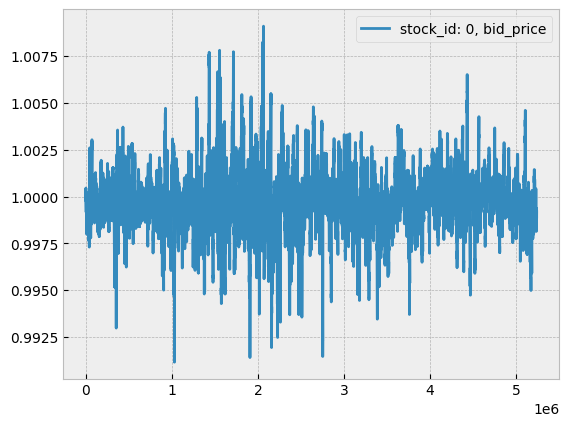

In [58]:
dict_[0][1]['bid_price'].plot(label='stock_id: '+str(dict_[0][0])+', bid_price')
plt.legend()
plt.show()

In [59]:
dict_[0][1]['target']

0         -3.030
191        0.390
382        4.220
573        5.450
764        3.170
           ...  
5236980    3.999
5237180    3.190
5237380   -0.170
5237580    3.110
5237780    0.761
Name: target, Length: 26455, dtype: float64